# Figure 1: Athletes Brain Study - Refactored

This notebook demonstrates the refactored, modular approach to generating Figure 1 for the athletes brain study.
The analysis has been organized into reusable modules within the `athletes_brain.fig1` package.

## Setup and Imports

Import the refactored modules from our package.

In [1]:
# Standard imports
from pathlib import Path
import pandas as pd
import numpy as np

# Import our refactored modules
from athletes_brain.fig1 import (
    Fig1Config,
    AthletesBrainDataLoader,
    GroupComparison,
    BrainPlotter,
    generate_figure1
)

# Import specific functions for focused analysis
from athletes_brain.fig1.main import (
    analyze_specific_comparison,
    get_most_significant_regions
)

2025-08-13 16:26:26.947 | INFO     | athletes_brain.config:<module>:11 - PROJ_ROOT path is: /home/galkepler/Projects/athletes_brain


## Configuration

Set up the configuration and visualization settings.

In [2]:
# Initialize configuration
config = Fig1Config()

# Set up matplotlib configuration for consistent plots
config.setup_matplotlib_config()

# Display configuration
print(f"Atlas: {config.ATLAS}")
print(f"Metrics: {config.METRICS}")
print(f"Group labels: {config.CLIMBER_GROUP_LABEL}, {config.BJJ_GROUP_LABEL}, {config.CONTROL_GROUP_LABEL}")
print(f"P-value threshold: {config.P_THRESHOLD}")
print(f"Visualization range: [{config.VMIN}, {config.VMAX}]")

Atlas: schaefer2018tian2020_400_7
Metrics: ['gm_vol', 'adc']
Group labels: Climbing, Bjj, Control
P-value threshold: 0.05
Visualization range: [-5, 5]


## Quick Analysis: Generate Complete Figure 1

Use the main function to generate all comparisons and visualizations.

In [3]:
# Generate complete Figure 1
output_dir = Path("/media/storage/phd") / "athletes_brain" / "figures" / "fig1"
# generate_figure1(output_dir=output_dir, config=config)

## Step-by-Step Analysis

For more control, we can run each step individually using the modular components.

### 1. Data Loading

In [4]:
# Initialize data loader
data_loader = AthletesBrainDataLoader(config)

# Load all data
metric_data, parcels, nifti_path, nifti_matlab_path = data_loader.load_all_data()

print(f"Loaded {len(metric_data)} metrics")
print(f"Loaded {len(parcels)} brain parcels")
print(f"Metrics: {list(metric_data.keys())}")

# Display sample data (demographics)
d = metric_data["gm_vol"].drop_duplicates(subset=["subject_code"], keep="first")
print(f"N participants: {d.shape[0]}")


2025-08-13 16:26:28.181 | INFO     | athletes_brain.fig1.data_loader:load_metric_data:48 - Loading metric data...
2025-08-13 16:26:28.181 | INFO     | athletes_brain.fig1.data_loader:load_metric_data:54 - Loading gm_vol data


/home/galkepler/Projects/athletes_brain/athletes_brain/fig1/data_loader.py:57: DtypeWarning: Columns (1,8,9,10,11,12,68,74,78,79,80,81,82,84,85,86,87,92,93,94,95,96,97,99,113,116,121,122,123,124,125,132,133,134) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(self.processed_dir / f"{metric}.csv", index_col=0).reset_index(


2025-08-13 16:26:34.493 | INFO     | athletes_brain.fig1.data_loader:load_metric_data:74 - Loaded 472498 records for gm_vol
2025-08-13 16:26:34.493 | INFO     | athletes_brain.fig1.data_loader:load_metric_data:54 - Loading adc data


/home/galkepler/Projects/athletes_brain/athletes_brain/fig1/data_loader.py:57: DtypeWarning: Columns (16,23,24,25,26,27,33,39,43,44,45,46,47,49,50,51,52,57,58,59,60,61,62,64,78,81,86,87,88,89,96,97,98) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(self.processed_dir / f"{metric}.csv", index_col=0).reset_index(


2025-08-13 16:26:38.969 | INFO     | athletes_brain.fig1.data_loader:load_metric_data:74 - Loaded 494664 records for adc
2025-08-13 16:26:38.969 | SUCCESS  | athletes_brain.fig1.data_loader:load_metric_data:76 - Successfully loaded 2 metrics
2025-08-13 16:26:38.969 | INFO     | athletes_brain.fig1.data_loader:load_atlas_data:32 - Loading atlas data for schaefer2018tian2020_400_7
2025-08-13 16:26:38.988 | INFO     | athletes_brain.fig1.data_loader:load_atlas_data:39 - Loaded 454 parcels from atlas
Loaded 2 metrics
Loaded 454 brain parcels
Metrics: ['gm_vol', 'adc']
N participants: 1050


### 2. Statistical Analysis

In [5]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

def class_balance_weights(s, target_mix=None):
    # s: Series with values "True"/"False" for athlete/control (strings)
    p_obs = s.value_counts(normalize=True).to_dict()
    if target_mix is None:
        target_mix = { "True": 0.5, "False": 0.5 }  # choose your target mix
    return s.map(lambda g: target_mix[g] / p_obs[g])

def analyze_with_class_weights(df, target_mix=None, robust=None, metric: str = "adc"):
    d = df.dropna(subset=["value","target","sex","age_at_scan"]).copy()
    d["target"] = d["target"].astype(str)
    d["sex"]    = d["sex"].astype(str)
    d["age_c"]  = d["age_at_scan"] - d["age_at_scan"].mean()
    w = class_balance_weights(d["target"], target_mix=target_mix)

    formula = ("value ~ C(target, Treatment(reference='False')) "
               "+ C(sex) + age_c + I(age_c**2)")
    if "vol" in metric:
        formula += " + tiv"
    
    fit = smf.wls(formula, data=d, weights=w).fit(cov_type=(robust or "nonrobust"))

    # effect (athletes vs controls) is the coefficient on the target indicator:
    coef_name = [k for k in fit.params.index if k.startswith("C(target")][0]
    t = fit.tvalues[coef_name]
    df_r = fit.df_resid
    r_partial = np.sign(t) * np.sqrt(t**2 / (t**2 + df_r))
    r2_partial = t**2 / (t**2 + df_r)
    out = {
        "target_mix": target_mix or {"True":0.5, "False":0.5},
        "coef_delta": float(fit.params[coef_name]),
        "t": float(t),
        "r_partial": float(r_partial),
        "r2_partial": float(r2_partial),
        "ci95": tuple(map(float, fit.conf_int().loc[coef_name])),
        "p_value": float(fit.pvalues[coef_name]),
        "n": len(d),
        # effective n is useful to report with weights:
        "effective_n": float((w.sum()**2) / (w.pow(2).sum()))
    }
    return out, fit


In [6]:
from statsmodels.stats.multitest import multipletests
from tqdm import tqdm

quad_age = False
interaction = True
results = {}
for metric, df in metric_data.items():
    results[metric] = {}
    print(f"Analyzing metric: {metric}")
    stats = parcels.copy()
    for i, row in tqdm(parcels.iterrows(), total=parcels.shape[0], desc="Processing parcels"):
        roi_df = df[df["index"] == row["index"]]
        out, res = analyze_with_class_weights(roi_df, metric=metric)
        for key, val in out.items():
            if key == "ci95":
                stats.loc[i, f"{key}_lower"] = val[0]
                stats.loc[i, f"{key}_upper"] = val[1]
            elif key == "target_mix":
                stats.loc[i, f"{key}_athlete"] = val["True"]
                stats.loc[i, f"{key}_control"] = val["False"]
            else:
                stats.loc[i, key] = val
        # break
    pvals = stats["p_value"].values
    _, corrected_pvals, _, _ = multipletests(pvals, method="fdr_bh")
    stats["p_value_corrected"] = corrected_pvals
    results[metric]["athletes_vs_controls"] = stats
    # break

Analyzing metric: gm_vol


Processing parcels:   0%|          | 0/454 [00:00<?, ?it/s]

Processing parcels: 100%|██████████| 454/454 [00:06<00:00, 75.19it/s]


Analyzing metric: adc


Processing parcels: 100%|██████████| 454/454 [00:05<00:00, 76.64it/s]


In [7]:
# # roi_df["group"].unique()
# sampled = metric_data["gm_vol"]["subject_code"].sample(100).tolist()
# print(list(metric_data["gm_vol"].query("subject_code in @sampled").columns))

# metric_data["gm_vol"].query("subject_code in @sampled")[['subject_code', 'age_at_scan', 'sex', 'session_id', 'study', 'group', 'condition', 'index', 'name', 'base_name', 'Label Name', 'network', 'component', 'hemisphere', 'value', 'total_gm_volume', 'tiv']].to_csv("~/Downloads/Gaia_example.csv")

In [8]:
from statsmodels.stats.multitest import multipletests
from tqdm import tqdm

for metric, df in metric_data.items():
    print(f"Analyzing metric: {metric}")
    for group in ["Climbing","Bjj"]:
        group_df = df[(df["group"] == group) | (~df["target"].astype(bool))]
        stats = parcels.copy()
        for i, row in tqdm(parcels.iterrows(), total=parcels.shape[0], desc="Processing parcels"):
            roi_df = group_df[group_df["index"] == row["index"]]
            out, res = analyze_with_class_weights(roi_df, metric=metric)
            for key, val in out.items():
                if key == "ci95":
                    stats.loc[i, f"{key}_lower"] = val[0]
                    stats.loc[i, f"{key}_upper"] = val[1]
                elif key == "target_mix":
                    stats.loc[i, f"{key}_athlete"] = val["True"]
                    stats.loc[i, f"{key}_control"] = val["False"]
                else:
                    stats.loc[i, key] = val
            # break
        pvals = stats["p_value"].values
        _, corrected_pvals, _, _ = multipletests(pvals, method="fdr_bh")
        stats["p_value_corrected"] = corrected_pvals
        results[metric][f"{group.lower()}_vs_controls"] = stats

        # break

Analyzing metric: gm_vol


Processing parcels: 100%|██████████| 454/454 [00:05<00:00, 82.63it/s]


Analyzing metric: adc


Processing parcels: 100%|██████████| 454/454 [00:05<00:00, 83.11it/s]


In [15]:
from statsmodels.stats.multitest import multipletests
from tqdm import tqdm

groups = ["climbing","bjj"]
reference_group = "climbing"

for metric, df in metric_data.items():
    print(f"Analyzing metric: {metric}")
    group_df = df[(df["target"].astype(bool)) & (df["group"].str.lower().isin(groups))]
    # reformat "target" to the reference group
    group_df["target"] = group_df["group"].str.lower().apply(lambda x: "True" if x == reference_group else "False")
    group_df["target"] = group_df["target"].astype(str)

    stats = parcels.copy()
    for i, row in tqdm(parcels.iterrows(), total=parcels.shape[0], desc="Processing parcels"):
        roi_df = group_df[group_df["index"] == row["index"]]
        out, res = analyze_with_class_weights(roi_df, metric=metric)
        for key, val in out.items():
            if key == "ci95":
                stats.loc[i, f"{key}_lower"] = val[0]
                stats.loc[i, f"{key}_upper"] = val[1]
            elif key == "target_mix":
                stats.loc[i, f"{key}_athlete"] = val["True"]
                stats.loc[i, f"{key}_control"] = val["False"]
            else:
                stats.loc[i, key] = val
        # break
    pvals = stats["p_value"].values
    _, corrected_pvals, _, _ = multipletests(pvals, method="fdr_bh")
    stats["p_value_corrected"] = corrected_pvals
    results[metric]["climbing_vs_bjj"] = stats

    # break

/tmp/ipykernel_846173/3960937403.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df["target"] = group_df["group"].str.lower().apply(lambda x: "True" if x == reference_group else "False")
/tmp/ipykernel_846173/3960937403.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df["target"] = group_df["target"].astype(str)


Analyzing metric: gm_vol


Processing parcels: 100%|██████████| 454/454 [00:03<00:00, 131.46it/s]
/tmp/ipykernel_846173/3960937403.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df["target"] = group_df["group"].str.lower().apply(lambda x: "True" if x == reference_group else "False")
/tmp/ipykernel_846173/3960937403.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df["target"] = group_df["target"].astype(str)


Analyzing metric: adc


Processing parcels: 100%|██████████| 454/454 [00:03<00:00, 142.26it/s]


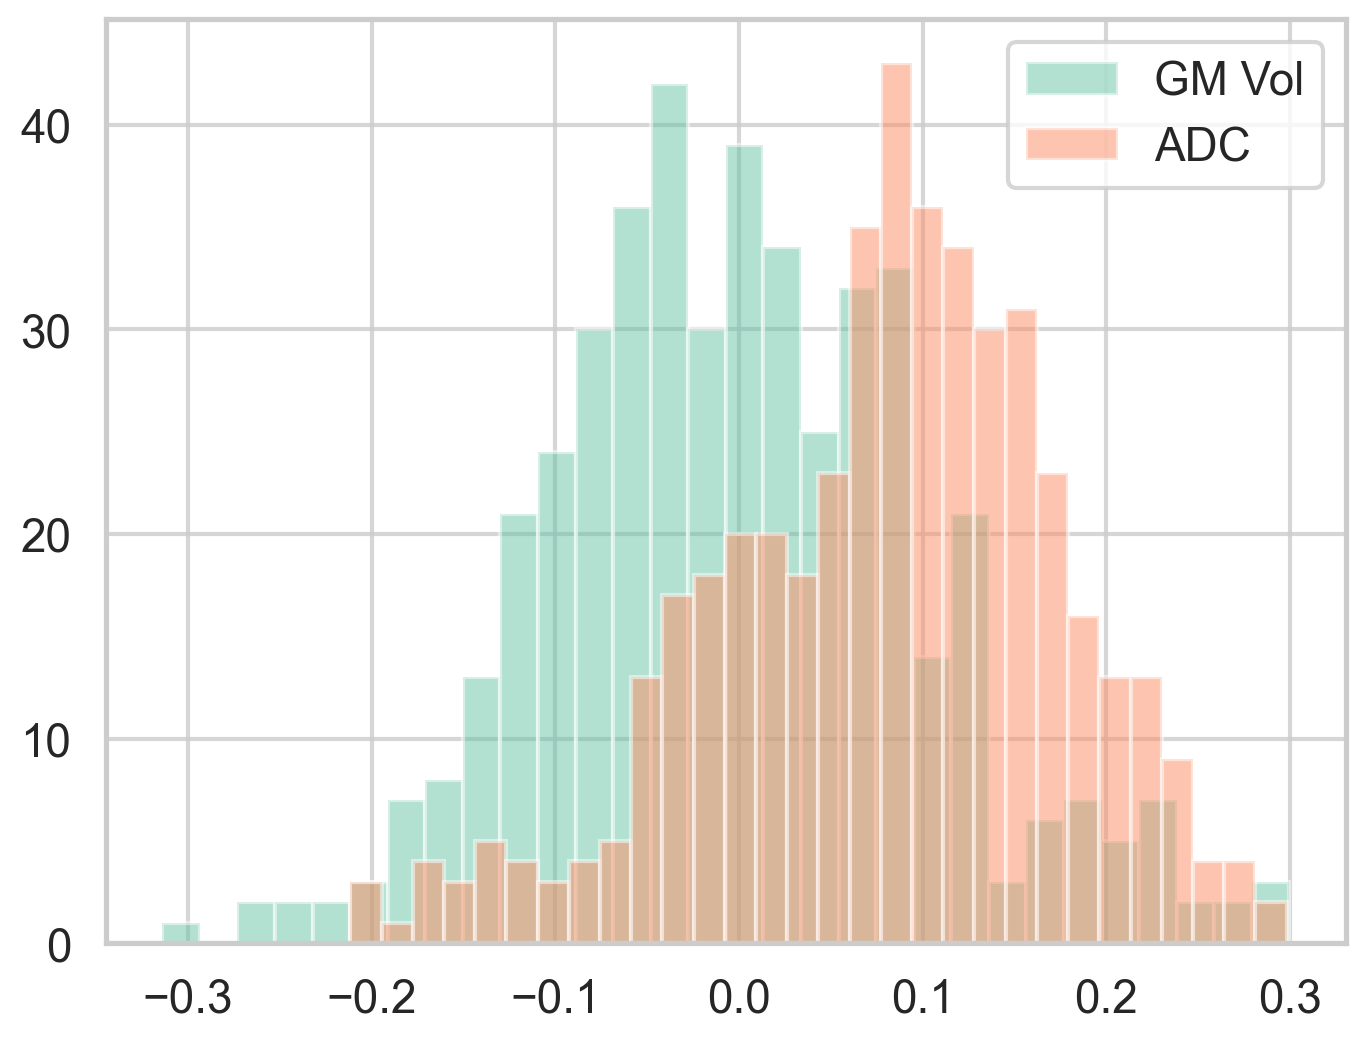

In [16]:
import matplotlib.pyplot as plt
# stats["coef_delta"].quantile([0.025, 0.975])

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.hist(results["gm_vol"]["climbing_vs_bjj"]["r_partial"], bins=30, alpha=0.5, label='GM Vol')
ax.hist(results["adc"]["climbing_vs_bjj"]["r_partial"], bins=30, alpha=0.5, label='ADC')
ax.legend()
# ax.hist(results["adc"]["climbing_vs_controls"]["
# results["gm_vol"]["athletes_vs_controls"]["r_partial"].hist()
# results["adc"]["athletes_vs_controls"]["r_partial"].hist()
# results["adc"]["climbing_vs_controls"]["r_partial"].hist()
# plt.axvline(x=-1.5e-05, color="red", linestyle="--")
# plt.axvline(x=1.5e-05, color="red", linestyle="--")
# Display the most significant regions

2025-08-13 16:30:43.073 | INFO     | athletes_brain.fig1.brain_visualization:plot_single_metric:277 - Creating brain plots for gm_vol
2025-08-13 16:30:43.073 | INFO     | athletes_brain.fig1.brain_visualization:setup_surfaces:31 - Setting up brain surfaces and parcellations
2025-08-13 16:30:43.078 | SUCCESS  | athletes_brain.fig1.brain_visualization:setup_surfaces:40 - Brain surfaces and parcellations loaded successfully
2025-08-13 16:30:43.078 | INFO     | athletes_brain.fig1.brain_visualization:prepare_value_maps:58 - Preparing value maps for r_partial
2025-08-13 16:30:43.104 | INFO     | athletes_brain.fig1.brain_visualization:prepare_value_maps:98 - Prepared maps with 200 LH, 200 RH, and 54 subcortical regions
2025-08-13 16:30:43.104 | INFO     | athletes_brain.fig1.brain_visualization:plot_cortical_surface:122 - Creating cortical surface plots
2025-08-13 16:30:43.119 | INFO     | athletes_brain.fig1.brain_visualization:plot_cortical_surface:144 - Plotting left hemisphere
2025-08-1

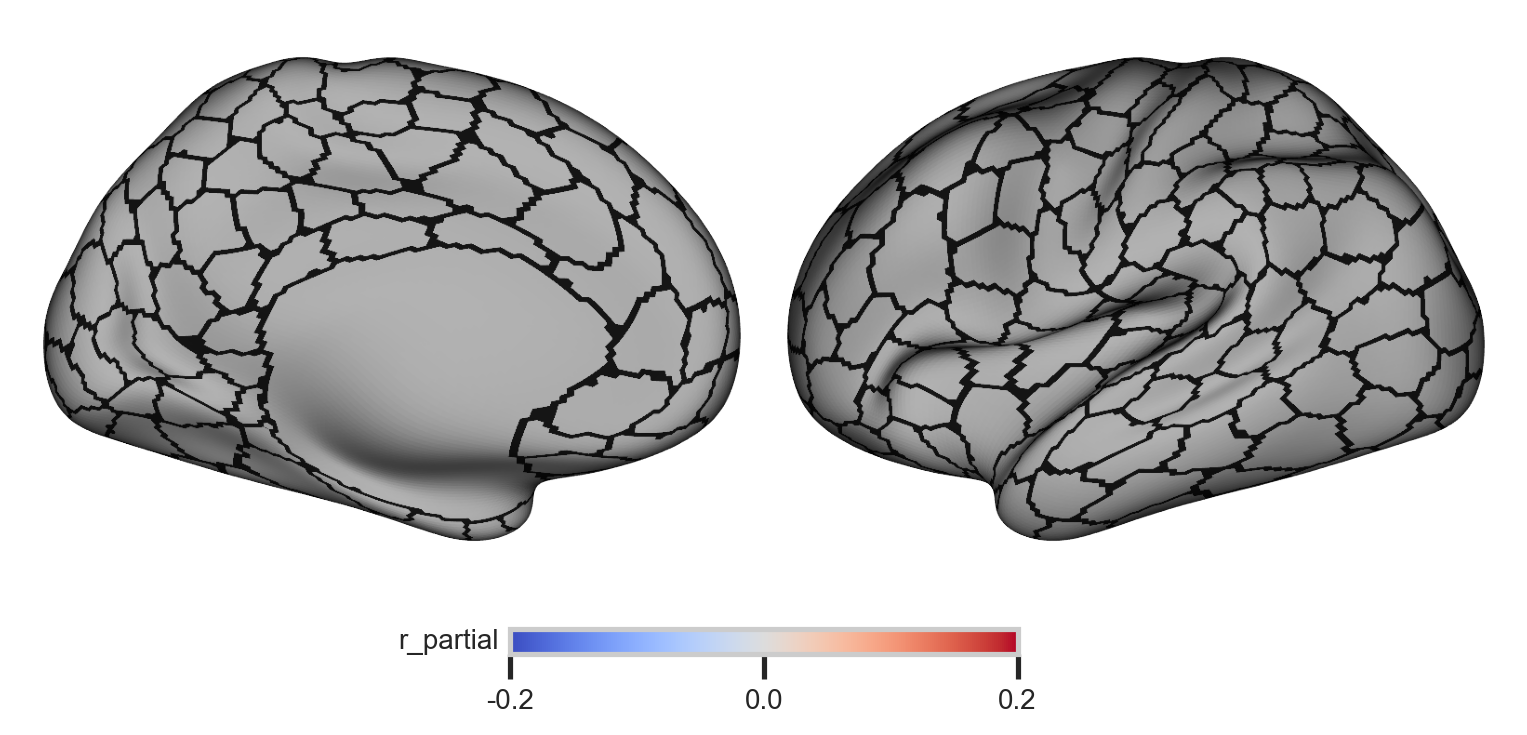

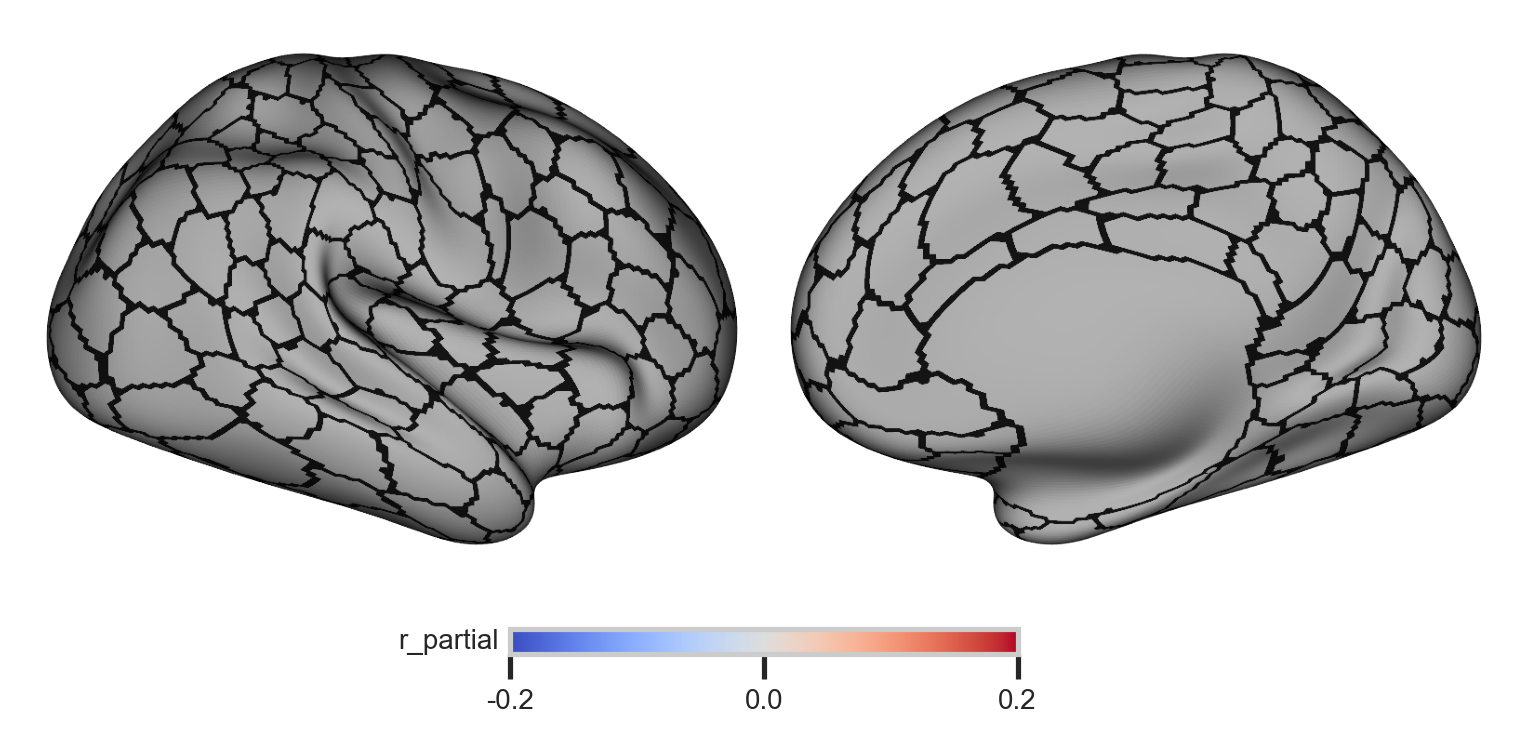

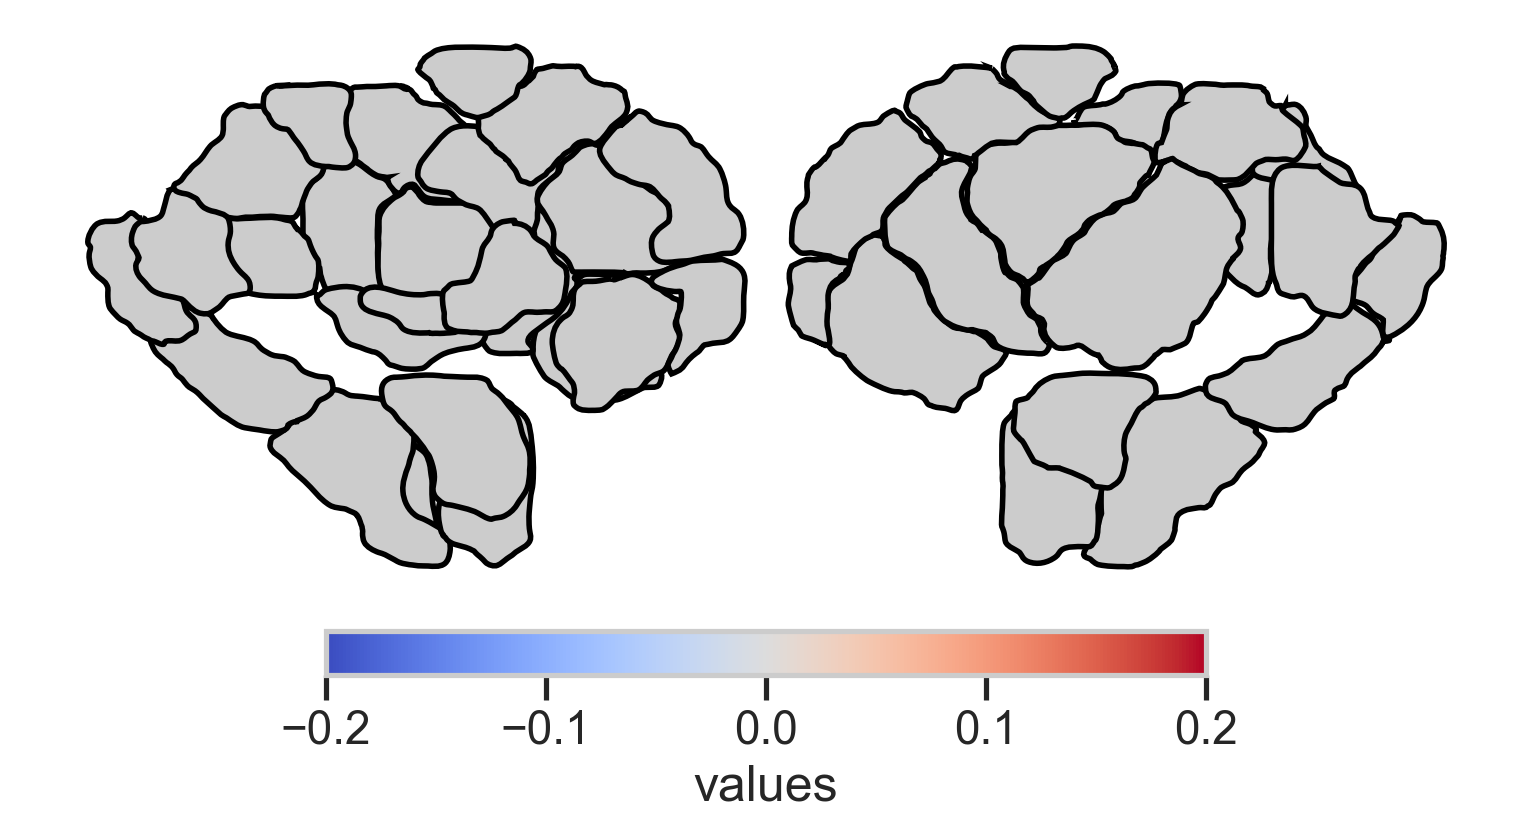

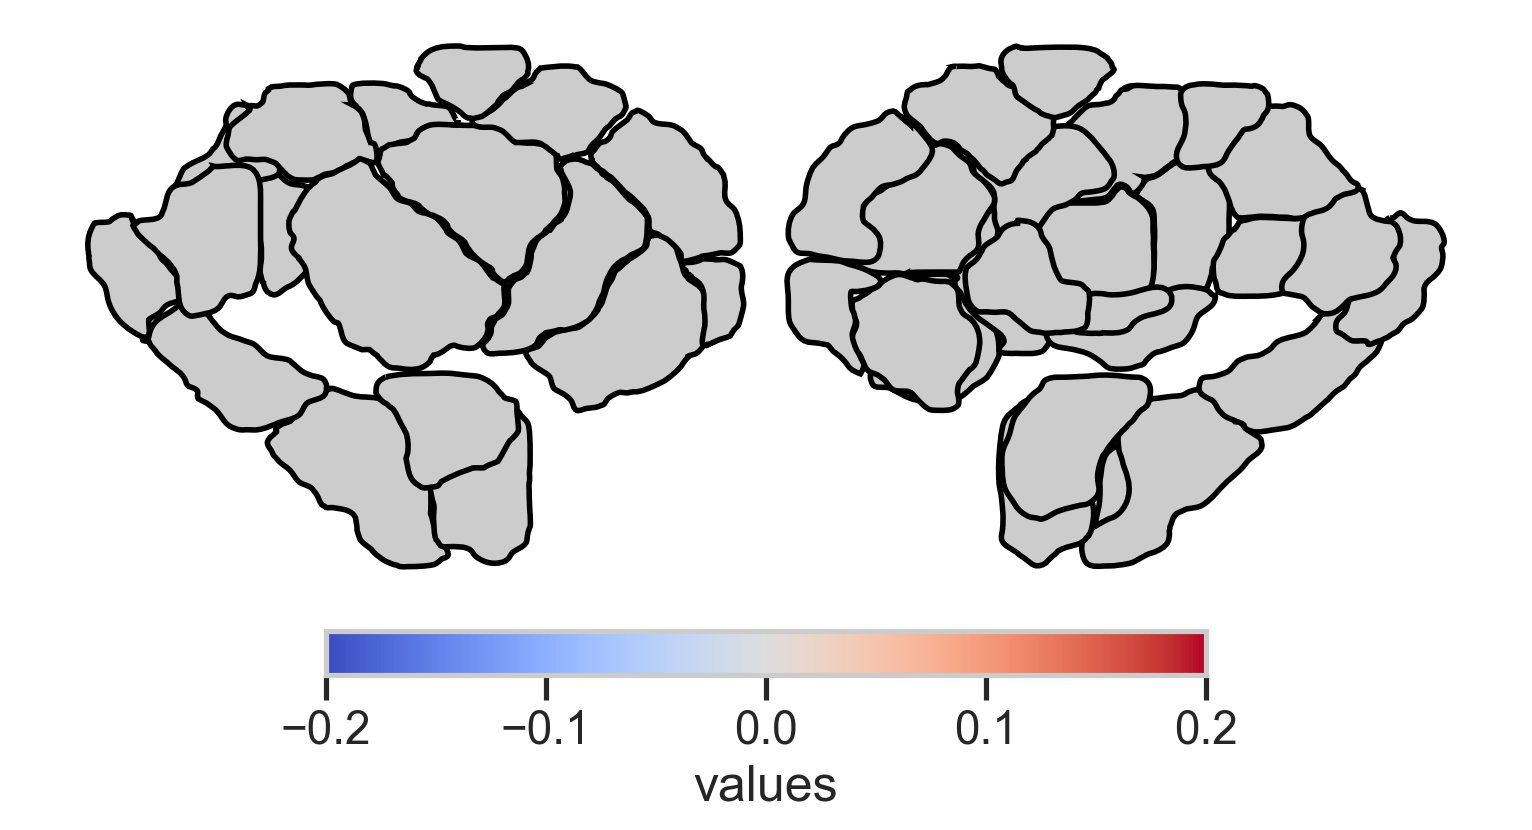

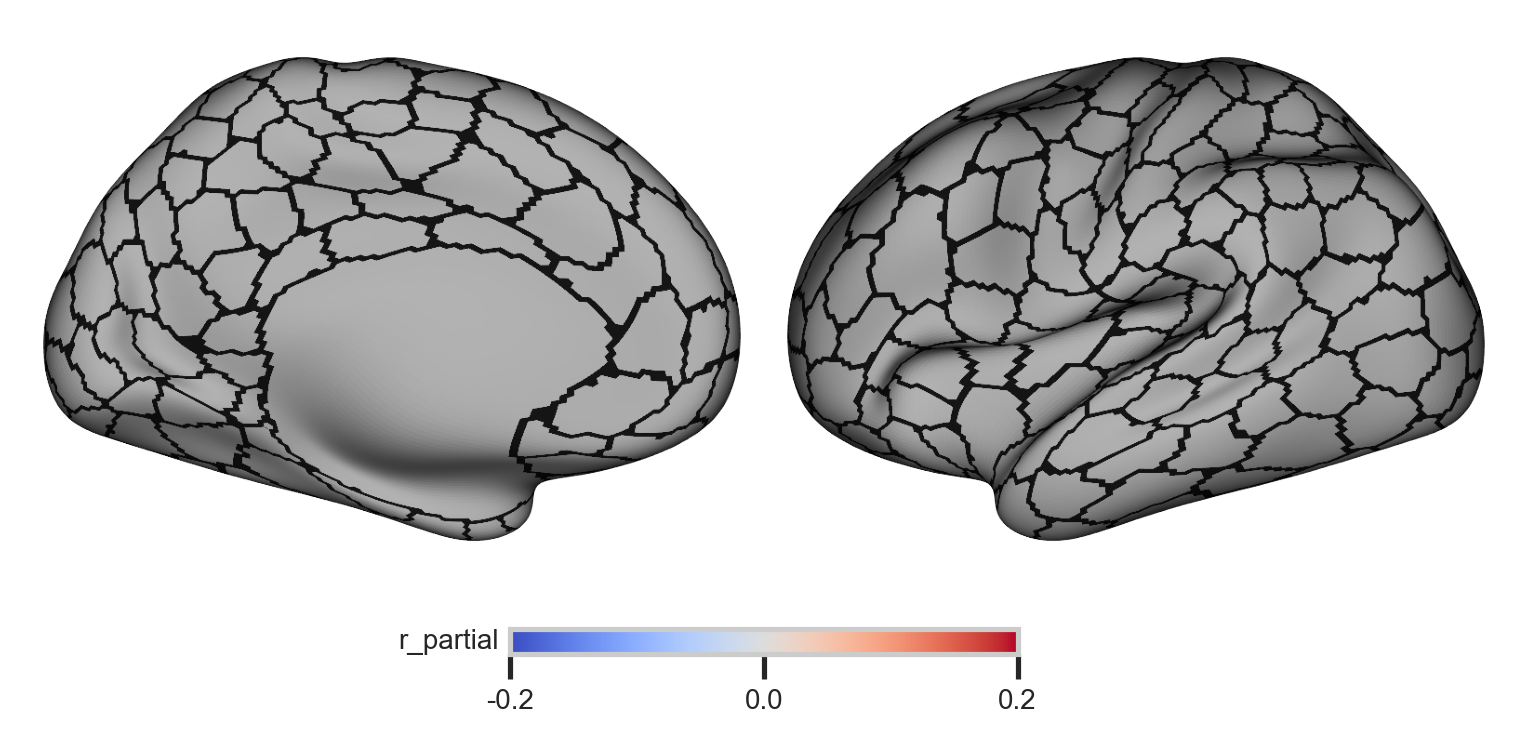

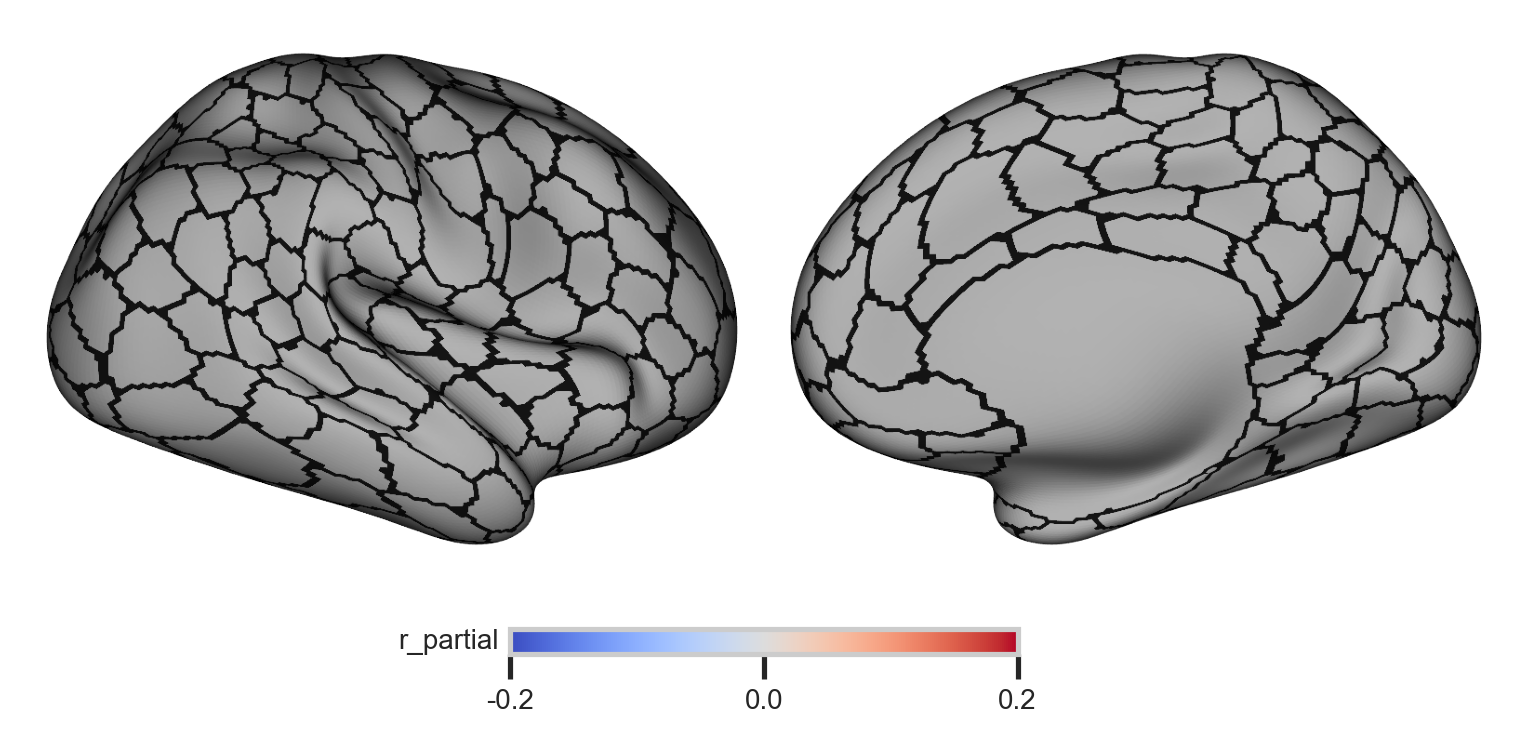

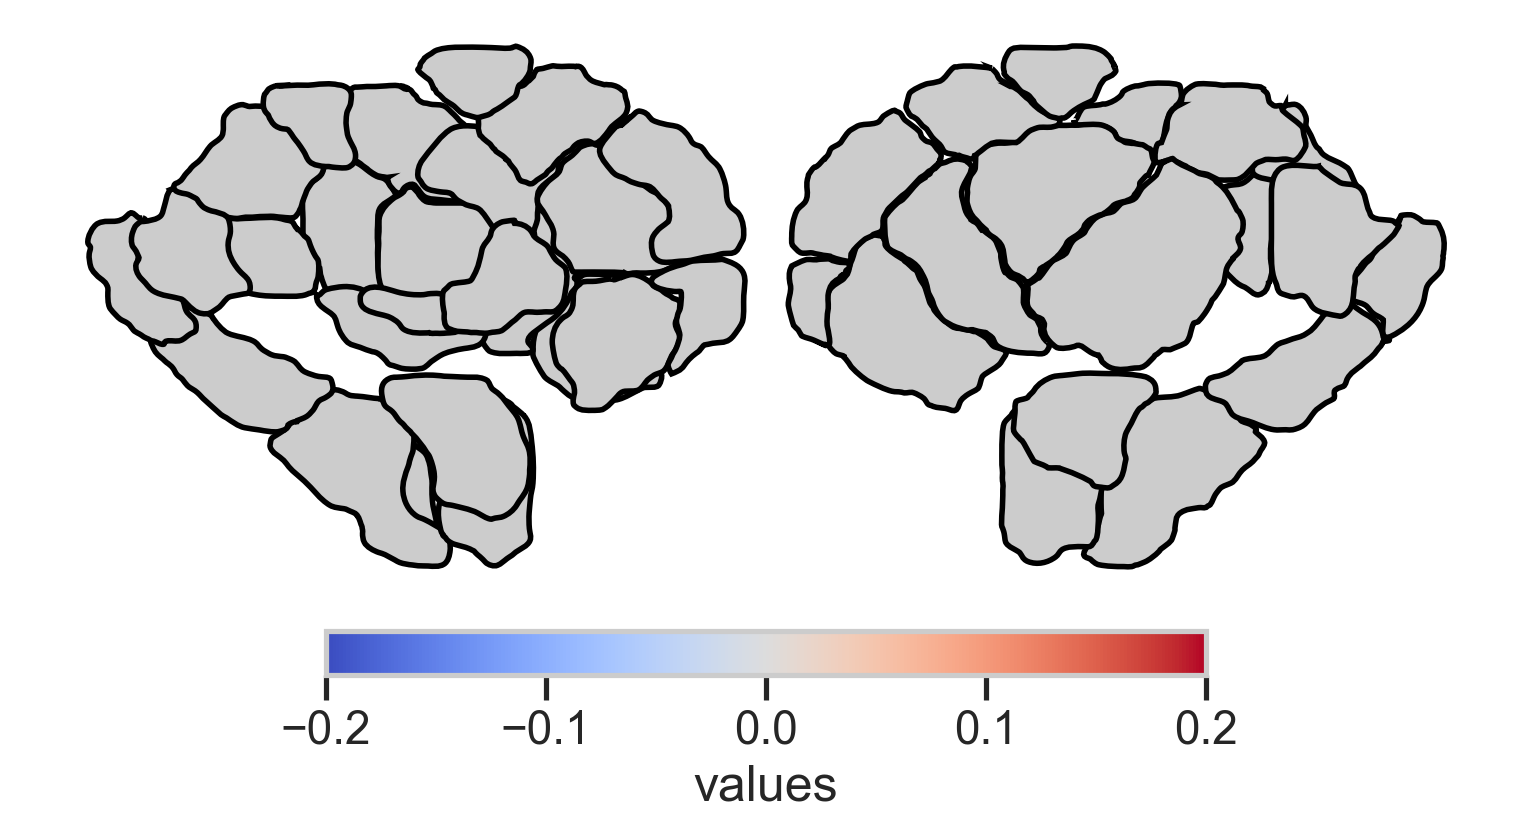

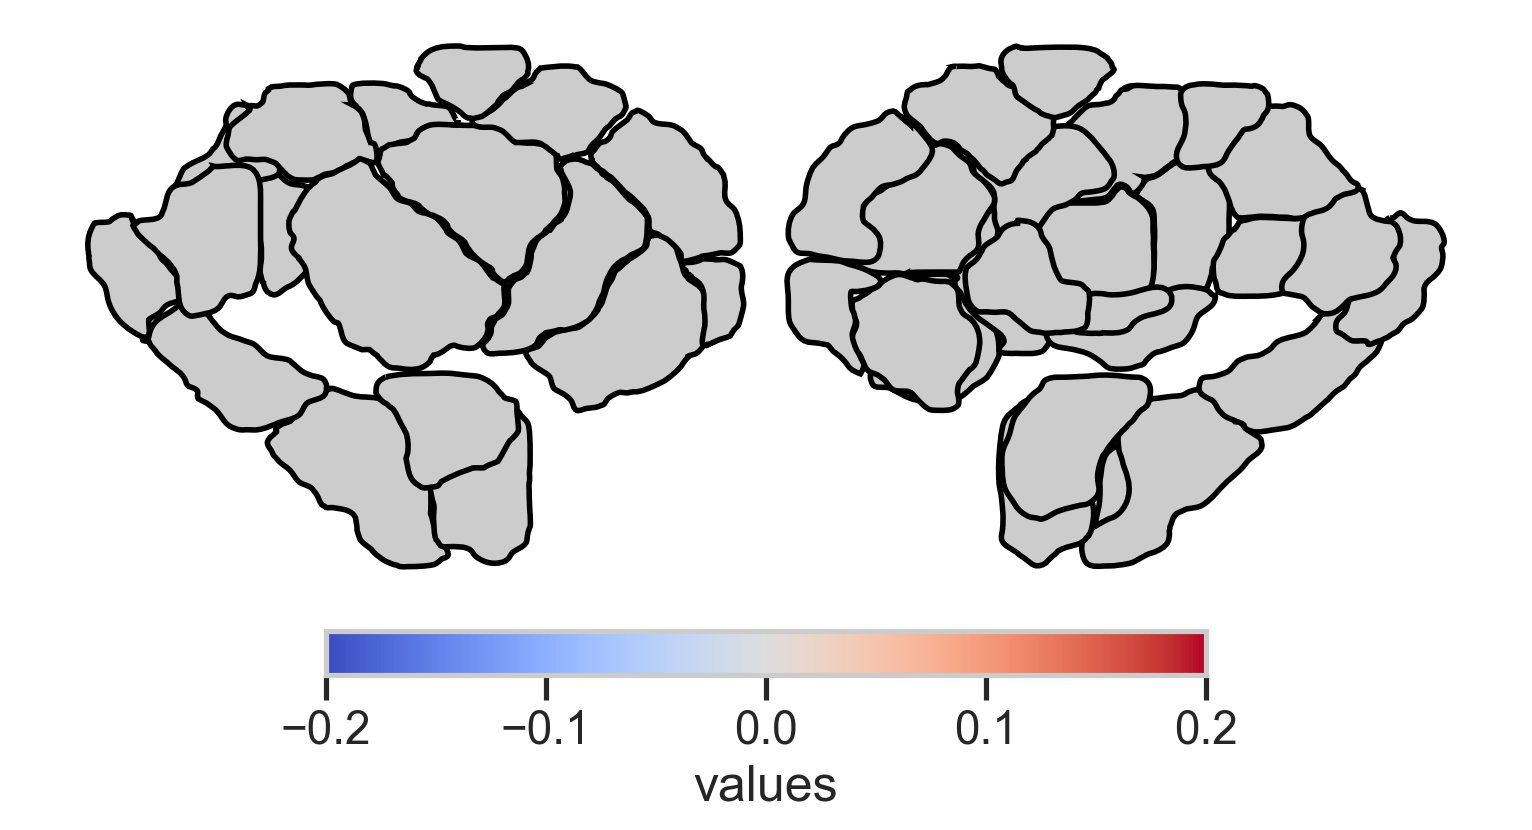

In [ ]:
# visualize
metrics = ["gm_vol", "adc"]
analysis_levels = ["athletes_vs_controls", "climbing_vs_controls", "bjj_vs_controls", "climbing_vs_bjj"]
# analysis_levels = ["climbing_vs_bjj"]
value_column = "r_partial"
vmin = -0.2
vmax = 0.2

for metric in metrics:
    for analysis_level in analysis_levels:
        metric_dir = output_dir / analysis_level / metric
        metric_dir.mkdir(parents=True, exist_ok=True)
        vis_df = results[metric][analysis_level].copy()
    
        vis_config = Fig1Config()
        vis_config.VMIN = vmin
        vis_config.VMAX = vmax

        plotter = BrainPlotter(vis_config)
        metric_dir = output_dir / analysis_level / metric
        metric_dir.mkdir(parents=True, exist_ok=True)

        plotter.plot_single_metric(
            results_df=vis_df,
            metric_key=metric,
            output_dir=metric_dir,
            p_column="p_value_corrected",
            value_column=value_column,
        )